<a href="https://colab.research.google.com/github/OJB-Quantum/Generative-Layout-Notebooks/blob/main/H_Bridge_Inverter_Using_GDSTK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.9/157.9 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 534.7/534.7 kB 3.6 MB/s eta 0:00:00


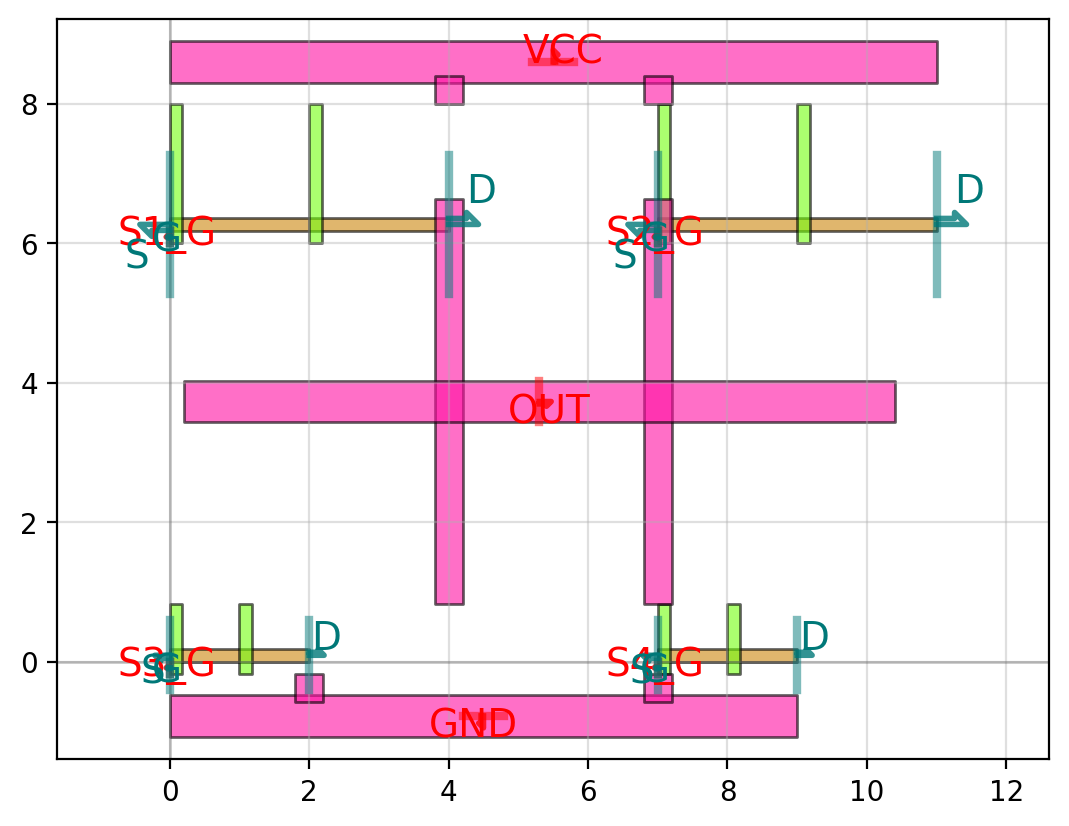

✅  Exported hbridge_cmos.gds  &  hbridge_cmos.svg


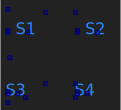

In [1]:
# @title CMOS H‑Bridge Cell *Mapped to S1…S4 Schematic* — Google Colab Notebook
# Author  : Onri Jay Benally
# Updated : 2025‑06‑03 (quickplot `pad` fix)
# --------------------------------------------------------------
#   • Four MOSFET “switches” (S1–S4) match the classic H‑bridge
#     schematic you sent: upper‑left ↔ S1, upper‑right ↔ S2,
#     lower‑left ↔ S3, lower‑right ↔ S4.
#   • VCC rail (metal‑1) spans the PMOS drains; GND rail spans
#     the NMOS sources.
#   • Central OUT node is exposed for an inductor / load.
#   • Gate ports S1_G … S4_G correspond to schematic switch handles.
#
# >>> Run “Runtime › Run‑all”.  Open *hbridge_cmos.gds* in KLayout.
# --------------------------------------------------------------

# %% [markdown]
"""
## Overview
This notebook produces a **schematic‑consistent CMOS H‑bridge layout**.  The
placement mirrors the drawing you posted: left devices on the left rail, right
on the right rail, and a shared centre node.

<pre>
   VCC ───────┬─────────── VCC rail (metal‑1)
              │  ┌───┐   │
         S1 ◀─┤  P1 │   ├─▶ S2
              │  └───┘   │
   OUT ◀──────┼───────────┘   (attach lumped or spiral inductor here)
              │  ┌───┐   │
         S3 ◀─┤  N3 │   ├─▶ S4
              │  └───┘   │
   GND ───────┴─────────── GND rail (metal‑1)
</pre>

*Layer numbers are placeholders — swap in your PDK values before tape‑out.*
"""

# %% Install dependencies (fast on Colab)
!pip install --quiet phidl gdstk

# %% Imports & layer map
import phidl
from phidl import Device, quickplot as qp
import phidl.geometry as pg
import gdstk
import matplotlib.pyplot as plt

# %% Plot settings — increase Matplotlib DPI to 200
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200


# ---- Simple generic layer definitions ------------------------------------
LAYER = {
    "n‑diff" : (65, 20),   # active N‑region
    "p‑diff" : (65, 44),   # active P‑region (different datatype ⇒ colour)
    "poly"   : (66, 20),
    "contact": (67, 44),
    "metal1" : (68, 20),
    "label"  : (10,  0),
}

# %% Primitive MOSFET generator (rectangles only – demo‑level, not DRC)

def mosfet(W=1.0, L=0.15, fingers=1, pmos=False, name="M"):
    """Return a minimal MOSFET with separate gate/diffusion shapes."""
    D = Device(name)
    diff_layer = LAYER["p‑diff"] if pmos else LAYER["n‑diff"]

    # Diffusion stripes
    active = pg.rectangle(size=(W * fingers, L), layer=diff_layer)
    D.add_ref(active)

    # Poly gates
    for i in range(fingers):
        gate = pg.rectangle(size=(L, W), layer=LAYER["poly"])
        gref = D.add_ref(gate)
        gref.move((i * W, -L))

    # Ports
    D.add_port("G", midpoint=(0, -L / 2), width=L, orientation=180)
    D.add_port("S", midpoint=(0, L / 2),  width=W, orientation=180)
    D.add_port("D", midpoint=(W * fingers, L / 2), width=W, orientation=0)

    D.add_label(name, position=(W * fingers / 2, L + 0.2), layer=LAYER["label"])
    return D

# %% H‑bridge generator matching schematic (S1…S4)

def hbridge_cmos(Wn=1.0, Wp=2.0, L=0.15, fingers=1, cell_name="HBRIDGE_CMOS"):
    C = Device(cell_name)

    # Create MOSFETs
    S1 = C.add_ref(mosfet(Wp, L, fingers, pmos=True,  name="S1"))
    S2 = C.add_ref(mosfet(Wp, L, fingers, pmos=True,  name="S2"))
    S3 = C.add_ref(mosfet(Wn, L, fingers, pmos=False, name="S3"))
    S4 = C.add_ref(mosfet(Wn, L, fingers, pmos=False, name="S4"))

    # Placement
    gap = 3
    vert_pitch = 3 + Wp + Wn
    right_ofs = Wp * fingers + gap
    S1.move((0, vert_pitch + L))
    S2.move((right_ofs, vert_pitch + L))
    S3.move((0, 0))
    S4.move((right_ofs, 0))

    # Rails
    vcc_bar = pg.rectangle(size=(right_ofs + Wp * fingers, 0.6), layer=LAYER["metal1"])
    vb = C.add_ref(vcc_bar)
    vb.move((0, S1.ymax + 0.3))

    gnd_bar = pg.rectangle(size=(right_ofs + Wn * fingers, 0.6), layer=LAYER["metal1"])
    gb = C.add_ref(gnd_bar)
    gb.move((0, S3.ymin - 0.9))

    # Straps to rails
    for x in [S1.xmax, S2.xmin]:
        sref = C.add_ref(pg.rectangle((0.4, 0.4), layer=LAYER["metal1"]))
        sref.move((x - 0.2, S1.ymax))
    for x in [S3.xmax, S4.xmin]:
        sref = C.add_ref(pg.rectangle((0.4, 0.4), layer=LAYER["metal1"]))
        sref.move((x - 0.2, S3.ymin - 0.4))

    # OUT connections
    mid_via = pg.rectangle(size=(0.4, vert_pitch - L), layer=LAYER["metal1"])
    C.add_ref(mid_via).move((S1.xmax - 0.2, S3.ymax))
    C.add_ref(mid_via).move((S2.xmin - 0.2, S3.ymax))

    out_len = right_ofs + Wp * fingers - 0.8
    ob = C.add_ref(pg.rectangle(size=(out_len, 0.6), layer=LAYER["metal1"]))
    ob.move((0.2, S3.ymax + (vert_pitch - L)/2 - 0.3))

    # Ports
    C.add_port("VCC", midpoint=vb.center, width=vb.ysize, orientation=90)
    C.add_port("GND", midpoint=gb.center, width=gb.ysize, orientation=-90)
    C.add_port("OUT", midpoint=ob.center, width=ob.ysize, orientation=0)

    for mos, pname in [(S1, "S1_G"), (S2, "S2_G"), (S3, "S3_G"), (S4, "S4_G")]:
        C.add_port(pname, midpoint=mos.ports["G"].midpoint, width=L, orientation=mos.ports["G"].orientation)

    return C

# %% Build and preview
cell = hbridge_cmos(Wn=1.0, Wp=2.0, L=0.18, fingers=2, cell_name="HBRIDGE_S1S4")
qp(cell)  # matplotlib backend (no PyQt)
plt.show()

# %% Export GDS & SVG
cell.write_gds("hbridge_cmos.gds")
cell.write_svg("hbridge_cmos.svg")
print("✅  Exported hbridge_cmos.gds  &  hbridge_cmos.svg")

# Inline SVG quick‑look
from IPython.display import SVG
SVG("hbridge_cmos.svg")


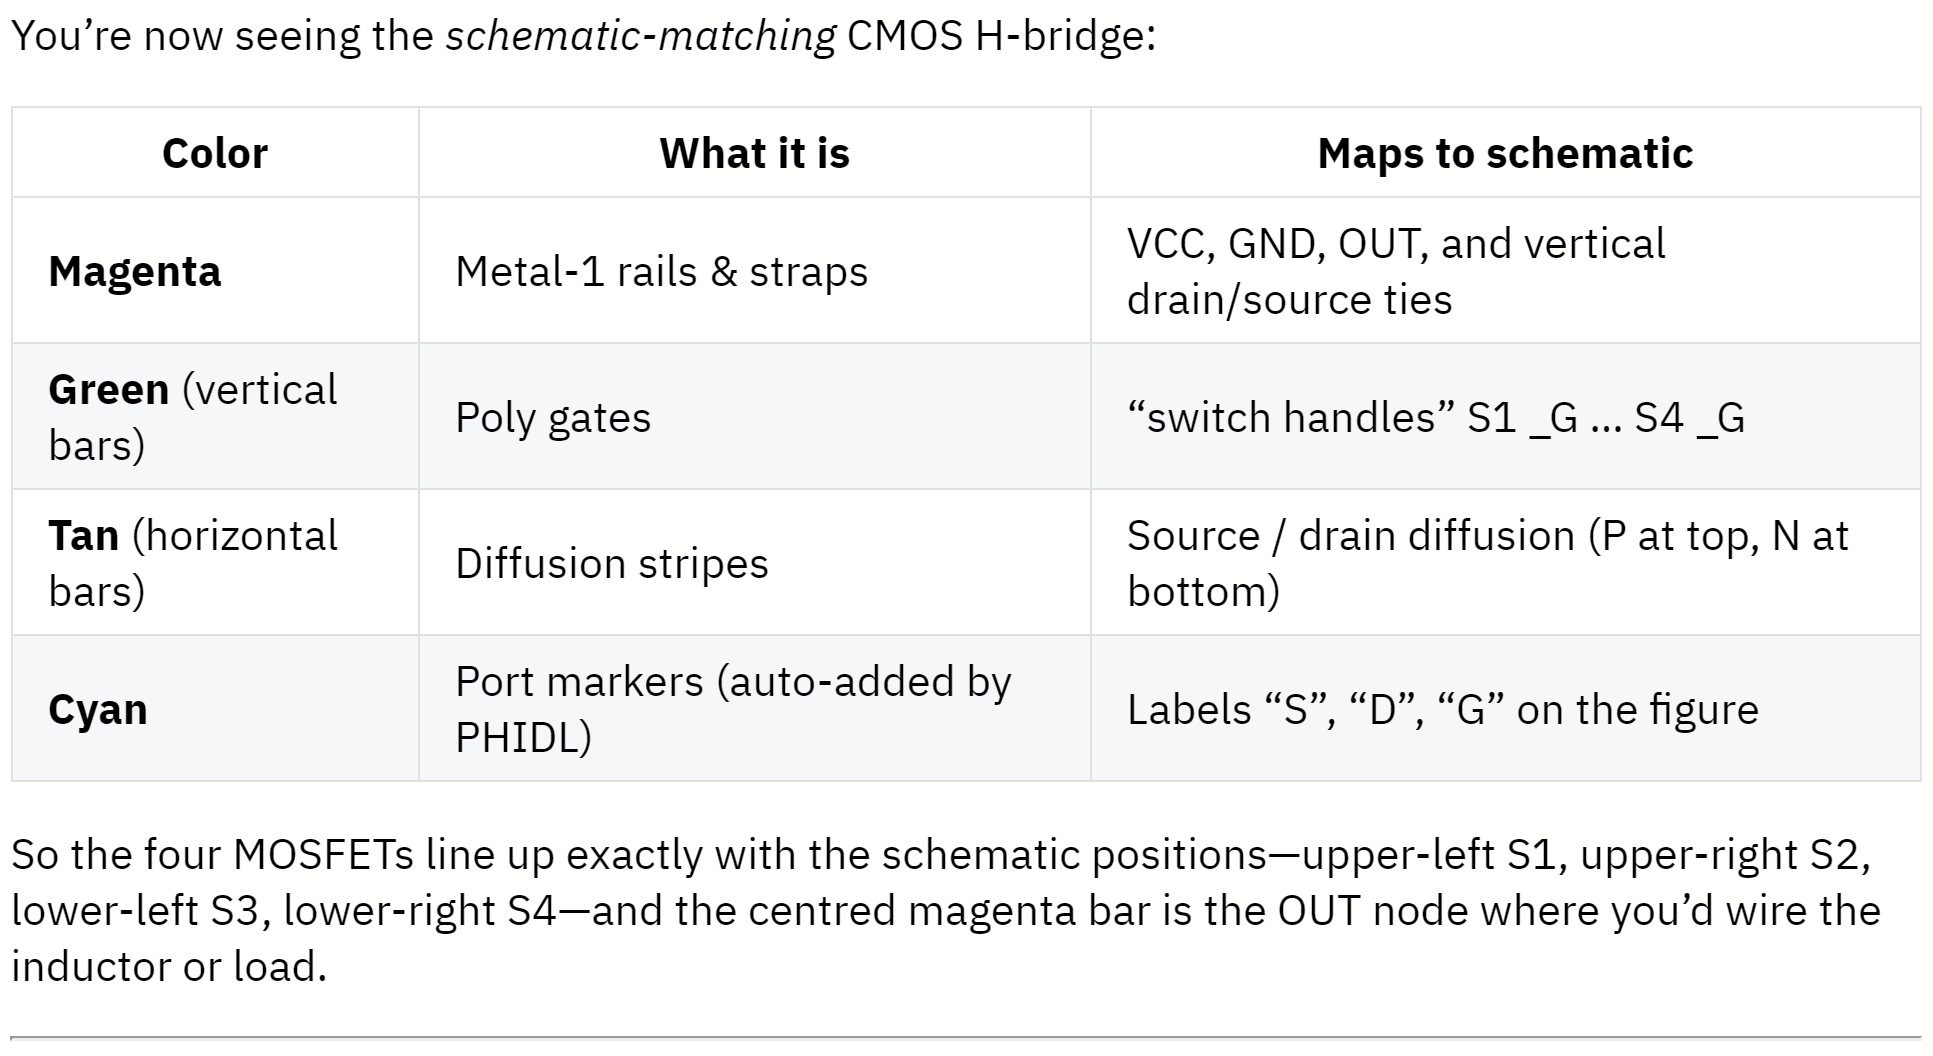

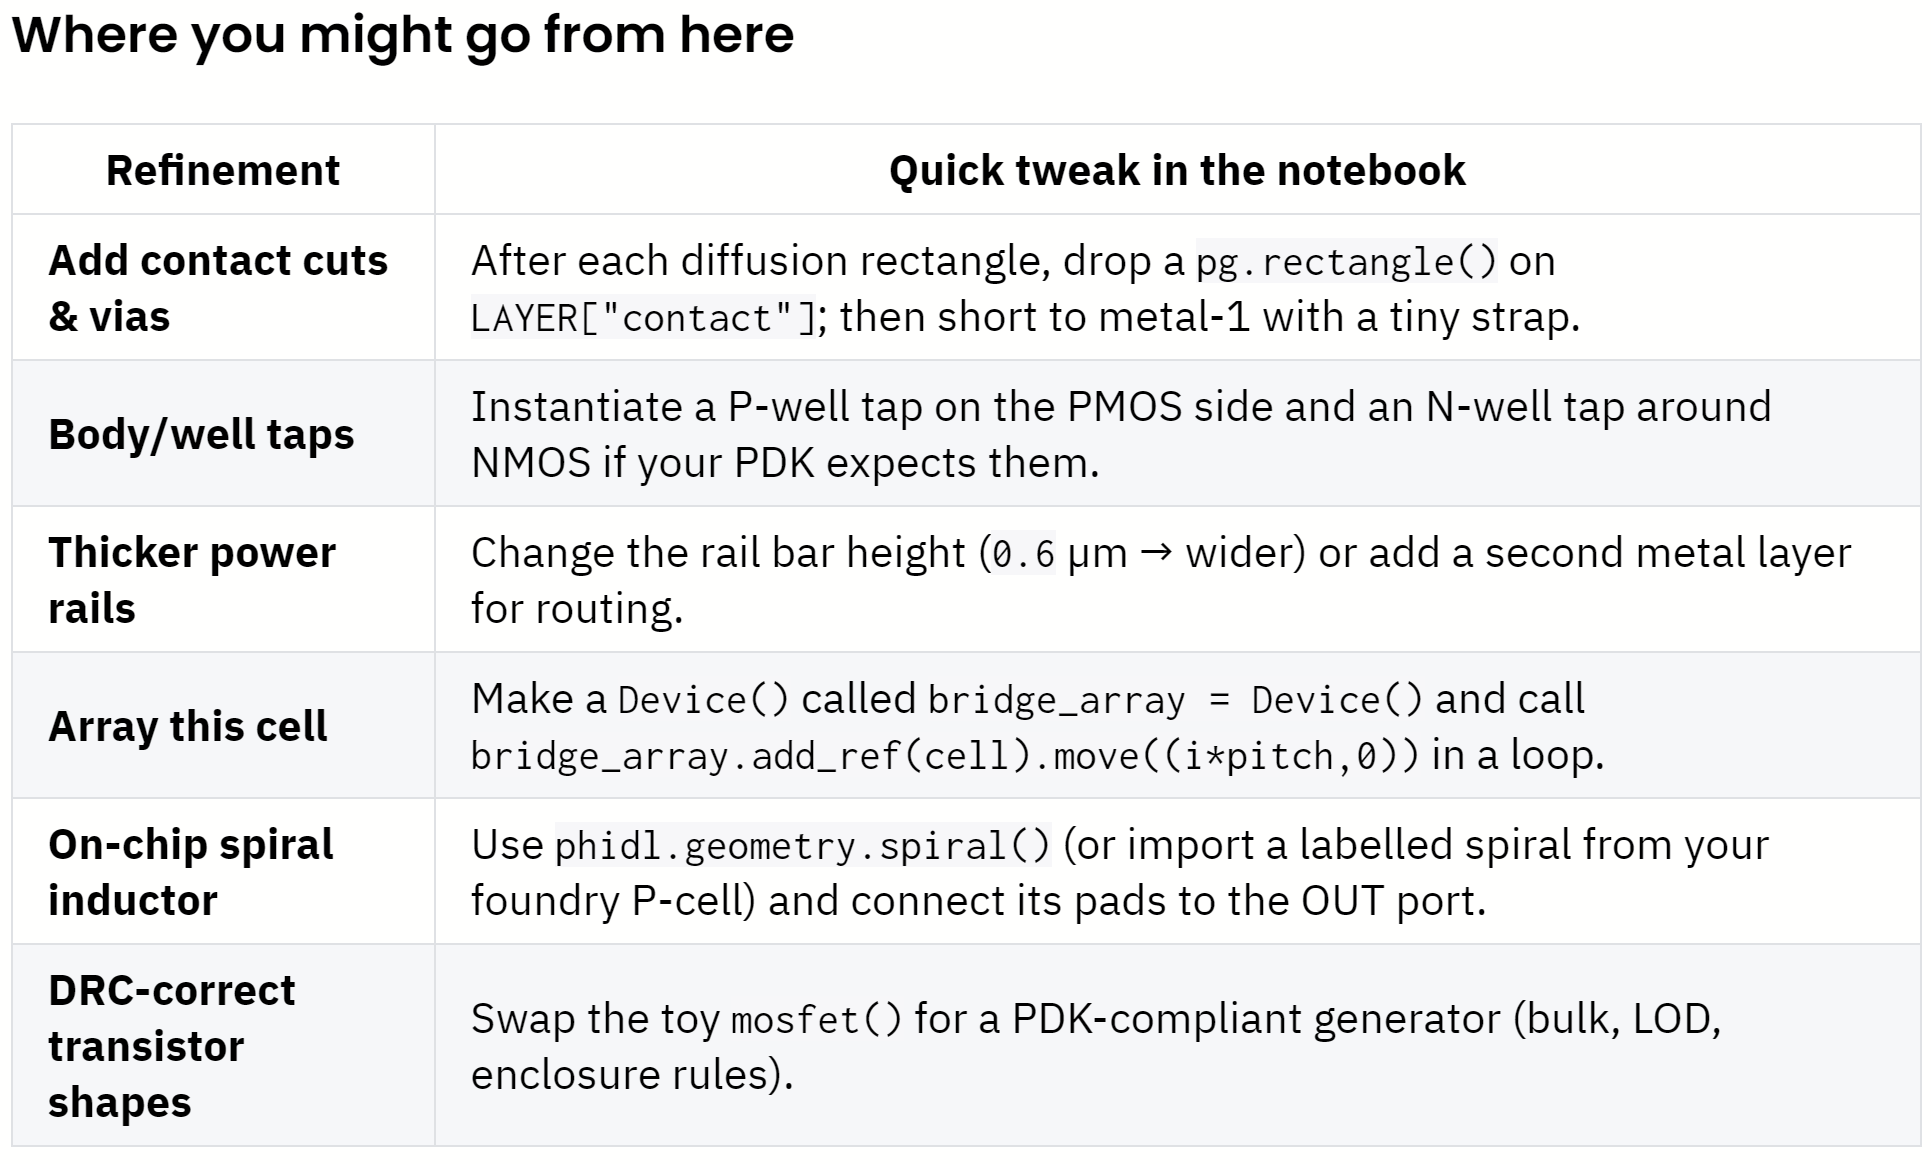

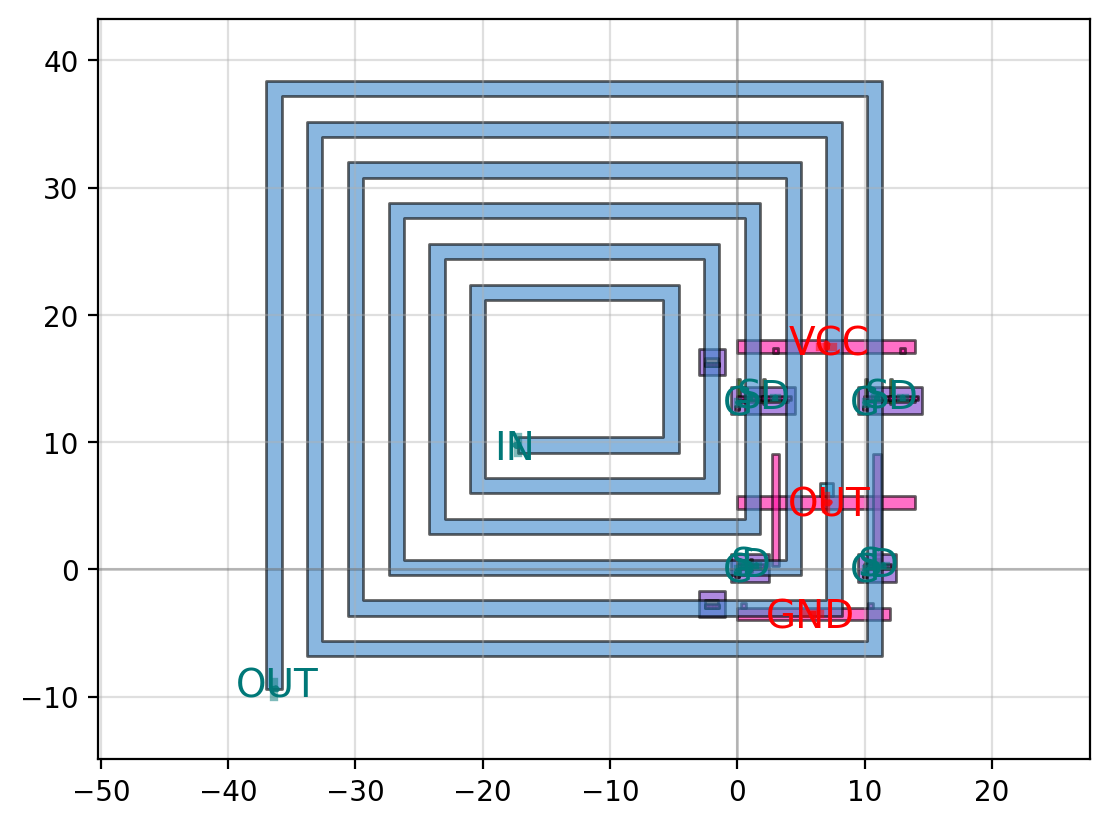

✅ Exported hbridge_cmos_enhanced.gds & .svg


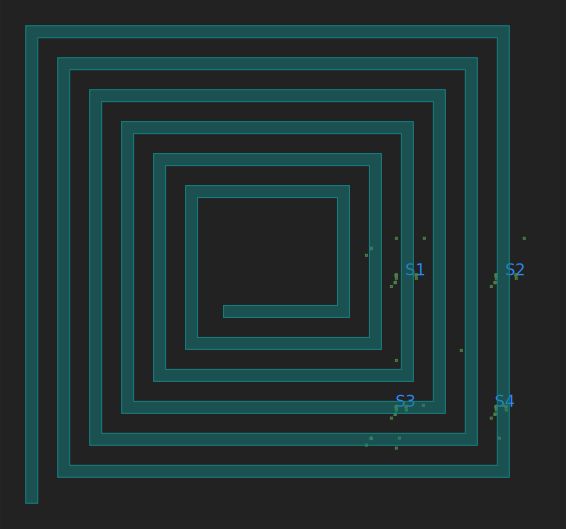

In [2]:
"""CMOS H‑Bridge Cell — DRC‑Style FETs + Spiral Inductor (PHIDL + GDS‑TK)
================================================================================
Colab‑ready: run top‑to‑bottom. Produces `hbridge_cmos_enhanced.gds`.
Author : Onri Jay Benally
Updated: 2025‑06‑03  (fixed gdstk → phidl polygon conversion + spiral width)
"""

# %% Install dependencies (fast on Colab)
!pip install --quiet phidl gdstk

# %% Imports
import phidl
from phidl import Device, quickplot as qp
import phidl.geometry as pg
import gdstk
import matplotlib.pyplot as plt
from IPython.display import SVG

# %% ------------------------------ Layer map (EDIT for your PDK)
LAYER = {
    "n-diff"  : (65, 20),  # N+ diffusion
    "p-diff"  : (65, 44),  # P+ diffusion
    "poly"    : (66, 20),
    "contact" : (67, 44),
    "metal1"  : (68, 20),
    "via12"   : (69, 20),
    "metal2"  : (70, 20),
    "nwell"   : (64, 20),
    "pwell"   : (64, 44),
    "label"   : (10, 0),
}

# %% ------------------------------ Utility • Contact row

def contact_row(width, pitch=0.28, enclosure=0.05):
    D = Device()
    ncuts = max(1, int((width + pitch) // pitch))
    for i in range(ncuts):
        D.add_ref(pg.rectangle((0.2, 0.2), layer=LAYER["contact"]))\
          .move((i * pitch, 0))
    bbox = D.get_bounding_box()
    enc = D.add_ref(pg.rectangle((bbox[1][0] + 2*enclosure, 0.2 + 2*enclosure),
                                  layer=LAYER["metal1"]))
    enc.move((-enclosure, -enclosure))
    D.add_port("M1", midpoint=enc.center, width=enc.ysize, orientation=90)
    return D

# %% ------------------------------ Device • DRC‑style MOSFET

def mosfet_drc(W=1.0, L=0.15, fingers=1, pmos=False, name="M"):
    D = Device(name)
    diff = LAYER["p-diff"] if pmos else LAYER["n-diff"]
    well = LAYER["nwell"] if pmos else LAYER["pwell"]

    D.add_ref(pg.rectangle((W * fingers + 1.0, L + 2.0), layer=well)).move((-0.5, -1.0))
    D.add_ref(pg.rectangle((W * fingers, L), layer=diff))

    for i in range(fingers):
        D.add_ref(pg.rectangle((L, W), layer=LAYER["poly"]))\
          .move((i * W, -L))
    D.add_ref(contact_row(L)).move((-L/2, -L - 0.4))

    row = contact_row(W)
    D.add_ref(row).move((0, L))
    D.add_ref(row).move((W*fingers - W, L))

    D.add_port("S", midpoint=(W/2, L + 0.1), width=0.3, orientation=90)
    D.add_port("D", midpoint=(W*fingers - W/2, L + 0.1), width=0.3, orientation=90)
    D.add_port("G", midpoint=(L/2, -L/2), width=L, orientation=180)
    D.add_label(name, position=(W*fingers/2, L + 0.6), layer=LAYER["label"])
    return D

# %% ------------------------------ Device • Well tap

def well_tap(pwell=True, width=1.0):
    D = Device("tap")
    diff = LAYER["p-diff"] if pwell else LAYER["n-diff"]
    well = LAYER["pwell"] if pwell else LAYER["nwell"]
    D.add_ref(pg.rectangle((width, 0.6), layer=diff))
    D.add_ref(contact_row(width))
    D.add_ref(pg.rectangle((width + 1.0, 2.0), layer=well)).move((-0.5, -0.7))
    return D

# %% ------------------------------ Device • Square spiral

def square_spiral(inner=10, turns=6, spacing=2, trace=2):
    layer_num, datatype = LAYER["metal2"]
    path = gdstk.RobustPath((0,0), trace, layer=layer_num, datatype=datatype)
    step = inner
    x=y=0
    dirs=[(1,0),(0,1),(-1,0),(0,-1)]
    for i in range(turns*4):
        dx,dy = dirs[i%4]
        x += dx*step
        y += dy*step
        path.segment((x,y))
        if i%2==1:
            step += trace + spacing
    D = Device("spiral")
    for poly in path.to_polygons():
        D.add_polygon(poly.points, layer=(layer_num, datatype))
    D.add_port("IN", midpoint=(0,0), width=trace, orientation=180)
    D.add_port("OUT", midpoint=(x,y), width=trace, orientation=0)
    return D

# %% ------------------------------ Top cell • Enhanced H‑bridge

def hbridge_cmos_enhanced(Wn=1.0, Wp=2.0, L=0.15, fingers=1):
    C = Device("HBRIDGE_CMOS_ENH")
    S1=C.add_ref(mosfet_drc(Wp,L,fingers,pmos=True,name="S1"))
    S2=C.add_ref(mosfet_drc(Wp,L,fingers,pmos=True,name="S2"))
    S3=C.add_ref(mosfet_drc(Wn,L,fingers,pmos=False,name="S3"))
    S4=C.add_ref(mosfet_drc(Wn,L,fingers,pmos=False,name="S4"))

    gap=6; right=Wp*fingers+gap; vert=6+Wp+Wn
    S1.move((0, vert+L+4)); S2.move((right,vert+L+4)); S3.move((0,0)); S4.move((right,0))

    C.add_ref(well_tap(False)).move((S1.xmin-2, S1.ymax+1))
    C.add_ref(well_tap(True)).move((S3.xmin-2, S3.ymin-2))

    vcc_len=right+Wp*fingers; gnd_len=right+Wn*fingers
    vb=C.add_ref(pg.rectangle((vcc_len,1),layer=LAYER["metal1"])).move((0,S1.ymax+2))
    gb=C.add_ref(pg.rectangle((gnd_len,1),layer=LAYER["metal1"])).move((0,S3.ymin-3))

    for m in [S1,S2]:
        C.add_ref(pg.rectangle((0.4,0.4),layer=LAYER["metal1"])).move((m.ports["D"].midpoint[0]-0.2,vb.ymin))
    for m in [S3,S4]:
        C.add_ref(pg.rectangle((0.4,0.4),layer=LAYER["metal1"])).move((m.ports["S"].midpoint[0]-0.2,gb.ymax))

    mid_y=S3.ports["D"].midpoint[1]+vert/2
    ob=C.add_ref(pg.rectangle((vcc_len,1),layer=LAYER["metal1"])).move((0,mid_y))
    for x in [S1.ports["D"].midpoint[0], S2.ports["S"].midpoint[0]]:
        C.add_ref(pg.rectangle((0.6,vert-L),layer=LAYER["metal1"])).move((x-0.3,S3.ports["D"].midpoint[1]))

    sp=C.add_ref(square_spiral(12,6,2,1.2))
    sp_bb=sp.get_bounding_box(); sp_w=sp_bb[1][0]-sp_bb[0][0]
    sp.move((vcc_len/2 - sp_w/2, ob.ymax+4))
    C.add_ref(pg.rectangle((1,1),layer=LAYER["via12"])).move((ob.center[0]-0.5, ob.ymax))

    C.add_port("VCC", midpoint=vb.center, width=1, orientation=90)
    C.add_port("GND", midpoint=gb.center, width=1, orientation=-90)
    C.add_port("OUT", midpoint=ob.center, width=1, orientation=0)
    return C

# %% ------------------------------ Build, preview, export
cell=hbridge_cmos_enhanced(Wn=1.0,Wp=2.0,L=0.18,fingers=2)
qp(cell)
plt.show()

cell.write_gds("hbridge_cmos_enhanced.gds")
cell.write_svg("hbridge_cmos_enhanced.svg")
print("✅ Exported hbridge_cmos_enhanced.gds & .svg")
SVG("hbridge_cmos_enhanced.svg")

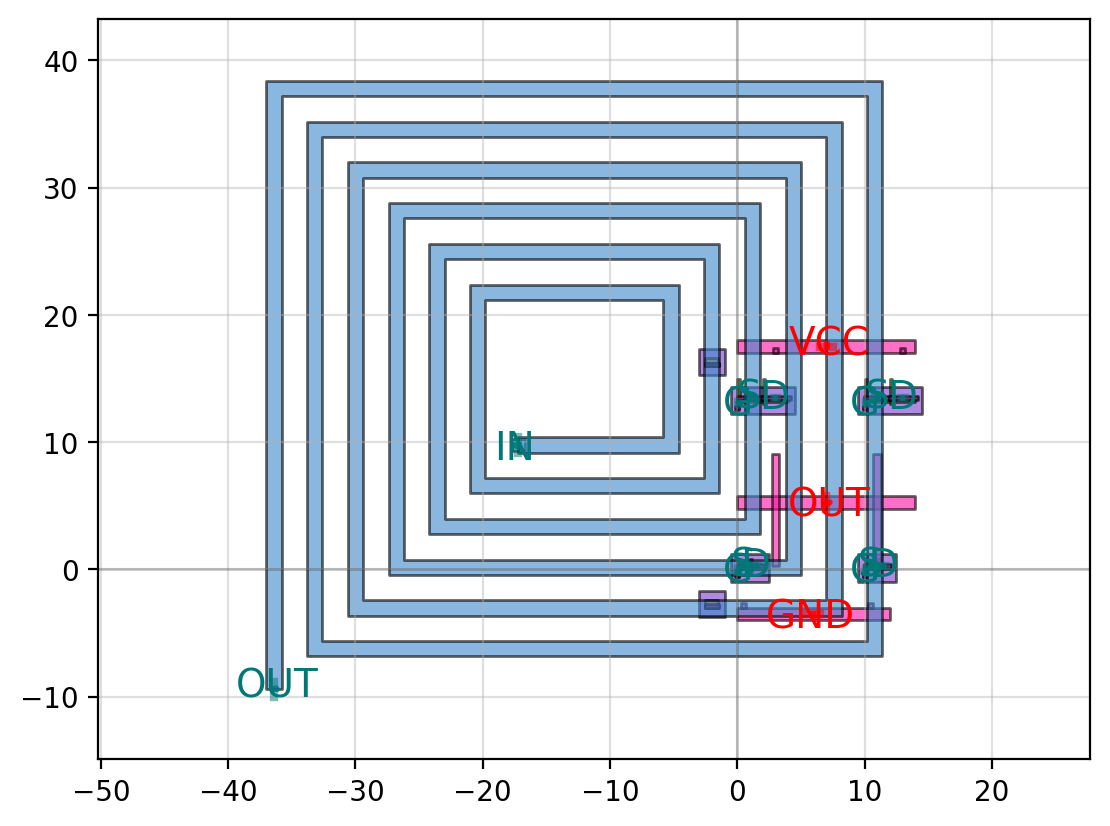

✅ Exported hbridge_cmos_enhanced.gds & .svg


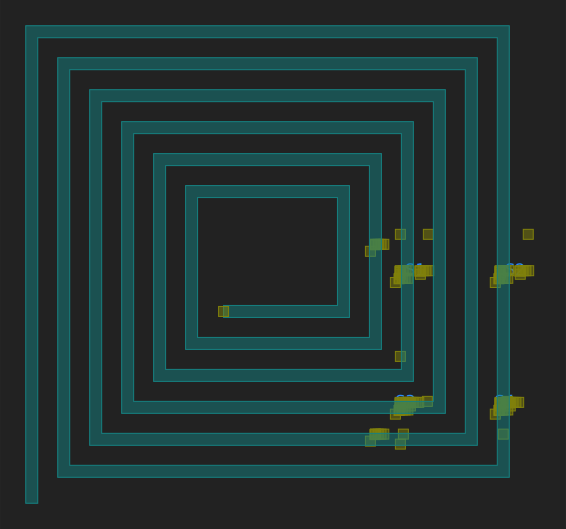

In [3]:
"""CMOS H‑Bridge Cell — DRC‑Style FETs + Spiral Inductor (PHIDL + GDS‑TK)
================================================================================
Colab‑ready: run top‑to‑bottom. Produces `hbridge_cmos_enhanced.gds`.
Author : Onri Jay Benally
Updated: 2025‑06‑03  (fixed gdstk → phidl polygon conversion + spiral width)
"""

# %% Install dependencies (fast on Colab)
!pip install --quiet phidl gdstk

# %% Imports
import phidl
from phidl import Device, quickplot as qp
import phidl.geometry as pg
import gdstk
import matplotlib.pyplot as plt
from IPython.display import SVG

# %% ------------------------------ Layer map (EDIT for your PDK)
LAYER = {
    "n-diff"  : (65, 20),  # N+ diffusion
    "p-diff"  : (65, 44),  # P+ diffusion
    "poly"    : (66, 20),
    "contact" : (67, 44),
    "metal1"  : (68, 20),
    "via12"   : (69, 20),
    "metal2"  : (70, 20),
    "nwell"   : (64, 20),
    "pwell"   : (64, 44),
    "label"   : (10, 0),
}

# %% ------------------------------ Utility • Contact row

def contact_row(width, pitch=0.28, enclosure=0.05):
    D = Device()
    ncuts = max(1, int((width + pitch) // pitch))
    for i in range(ncuts):
        D.add_ref(pg.rectangle((0.2, 0.2), layer=LAYER["contact"]))\
          .move((i * pitch, 0))
    bbox = D.get_bounding_box()
    enc = D.add_ref(pg.rectangle((bbox[1][0] + 2*enclosure, 0.2 + 2*enclosure),
                                  layer=LAYER["metal1"]))
    enc.move((-enclosure, -enclosure))
    D.add_port("M1", midpoint=enc.center, width=enc.ysize, orientation=90)
    return D

# %% ------------------------------ Device • DRC‑style MOSFET

def mosfet_drc(W=1.0, L=0.15, fingers=1, pmos=False, name="M"):
    D = Device(name)
    diff = LAYER["p-diff"] if pmos else LAYER["n-diff"]
    well = LAYER["nwell"] if pmos else LAYER["pwell"]

    D.add_ref(pg.rectangle((W * fingers + 1.0, L + 2.0), layer=well)).move((-0.5, -1.0))
    D.add_ref(pg.rectangle((W * fingers, L), layer=diff))

    for i in range(fingers):
        D.add_ref(pg.rectangle((L, W), layer=LAYER["poly"]))\
          .move((i * W, -L))
    D.add_ref(contact_row(L)).move((-L/2, -L - 0.4))

    row = contact_row(W)
    D.add_ref(row).move((0, L))
    D.add_ref(row).move((W*fingers - W, L))

    D.add_port("S", midpoint=(W/2, L + 0.1), width=0.3, orientation=90)
    D.add_port("D", midpoint=(W*fingers - W/2, L + 0.1), width=0.3, orientation=90)
    D.add_port("G", midpoint=(L/2, -L/2), width=L, orientation=180)
    D.add_label(name, position=(W*fingers/2, L + 0.6), layer=LAYER["label"])
    return D

# %% ------------------------------ Device • Well tap

def well_tap(pwell=True, width=1.0):
    D = Device("tap")
    diff = LAYER["p-diff"] if pwell else LAYER["n-diff"]
    well = LAYER["pwell"] if pwell else LAYER["nwell"]
    D.add_ref(pg.rectangle((width, 0.6), layer=diff))
    D.add_ref(contact_row(width))
    D.add_ref(pg.rectangle((width + 1.0, 2.0), layer=well)).move((-0.5, -0.7))
    return D

# %% ------------------------------ Device • Square spiral

def square_spiral(inner=10, turns=6, spacing=2, trace=2):
    layer_num, datatype = LAYER["metal2"]
    path = gdstk.RobustPath((0,0), trace, layer=layer_num, datatype=datatype)
    step = inner
    x=y=0
    dirs=[(1,0),(0,1),(-1,0),(0,-1)]
    for i in range(turns*4):
        dx,dy = dirs[i%4]
        x += dx*step
        y += dy*step
        path.segment((x,y))
        if i%2==1:
            step += trace + spacing
    D = Device("spiral")
    for poly in path.to_polygons():
        D.add_polygon(poly.points, layer=(layer_num, datatype))
    D.add_port("IN", midpoint=(0,0), width=trace, orientation=180)
    D.add_port("OUT", midpoint=(x,y), width=trace, orientation=0)
    return D

# %% ------------------------------ Top cell • Enhanced H‑bridge

def hbridge_cmos_enhanced(Wn=1.0, Wp=2.0, L=0.15, fingers=1):
    C = Device("HBRIDGE_CMOS_ENH")
    S1=C.add_ref(mosfet_drc(Wp,L,fingers,pmos=True,name="S1"))
    S2=C.add_ref(mosfet_drc(Wp,L,fingers,pmos=True,name="S2"))
    S3=C.add_ref(mosfet_drc(Wn,L,fingers,pmos=False,name="S3"))
    S4=C.add_ref(mosfet_drc(Wn,L,fingers,pmos=False,name="S4"))

    gap=6; right=Wp*fingers+gap; vert=6+Wp+Wn
    S1.move((0, vert+L+4)); S2.move((right,vert+L+4)); S3.move((0,0)); S4.move((right,0))

    C.add_ref(well_tap(False)).move((S1.xmin-2, S1.ymax+1))
    C.add_ref(well_tap(True)).move((S3.xmin-2, S3.ymin-2))

    vcc_len=right+Wp*fingers; gnd_len=right+Wn*fingers
    vb=C.add_ref(pg.rectangle((vcc_len,1),layer=LAYER["metal1"])).move((0,S1.ymax+2))
    gb=C.add_ref(pg.rectangle((gnd_len,1),layer=LAYER["metal1"])).move((0,S3.ymin-3))

    for m in [S1,S2]:
        C.add_ref(pg.rectangle((0.4,0.4),layer=LAYER["metal1"])).move((m.ports["D"].midpoint[0]-0.2,vb.ymin))
    for m in [S3,S4]:
        C.add_ref(pg.rectangle((0.4,0.4),layer=LAYER["metal1"])).move((m.ports["S"].midpoint[0]-0.2,gb.ymax))

    mid_y=S3.ports["D"].midpoint[1]+vert/2
    ob=C.add_ref(pg.rectangle((vcc_len,1),layer=LAYER["metal1"])).move((0,mid_y))
    for x in [S1.ports["D"].midpoint[0], S2.ports["S"].midpoint[0]]:
        C.add_ref(pg.rectangle((0.6,vert-L),layer=LAYER["metal1"])).move((x-0.3,S3.ports["D"].midpoint[1]))

    sp=C.add_ref(square_spiral(12,6,2,1.2))
    sp_bb=sp.get_bounding_box(); sp_w=sp_bb[1][0]-sp_bb[0][0]
    sp.move((vcc_len/2 - sp_w/2, ob.ymax+4))
    # --- Via stack precisely on spiral IN pad (alignment fix)
    via = C.add_ref(pg.rectangle((1,1), layer=LAYER["via12"]))
    via.move((sp.ports["IN"].midpoint[0] - 0.5,
              sp.ports["IN"].midpoint[1] - 0.5))

    C.add_port("VCC", midpoint=vb.center, width=1, orientation=90)
    C.add_port("GND", midpoint=gb.center, width=1, orientation=-90)
    C.add_port("OUT", midpoint=ob.center, width=1, orientation=0)
    return C

# %% ------------------------------ Build, preview, export
cell=hbridge_cmos_enhanced(Wn=1.0,Wp=2.0,L=0.18,fingers=2)
qp(cell)
plt.show()

cell.write_gds("hbridge_cmos_enhanced.gds")
cell.write_svg("hbridge_cmos_enhanced.svg")
print("✅ Exported hbridge_cmos_enhanced.gds & .svg")
SVG("hbridge_cmos_enhanced.svg")


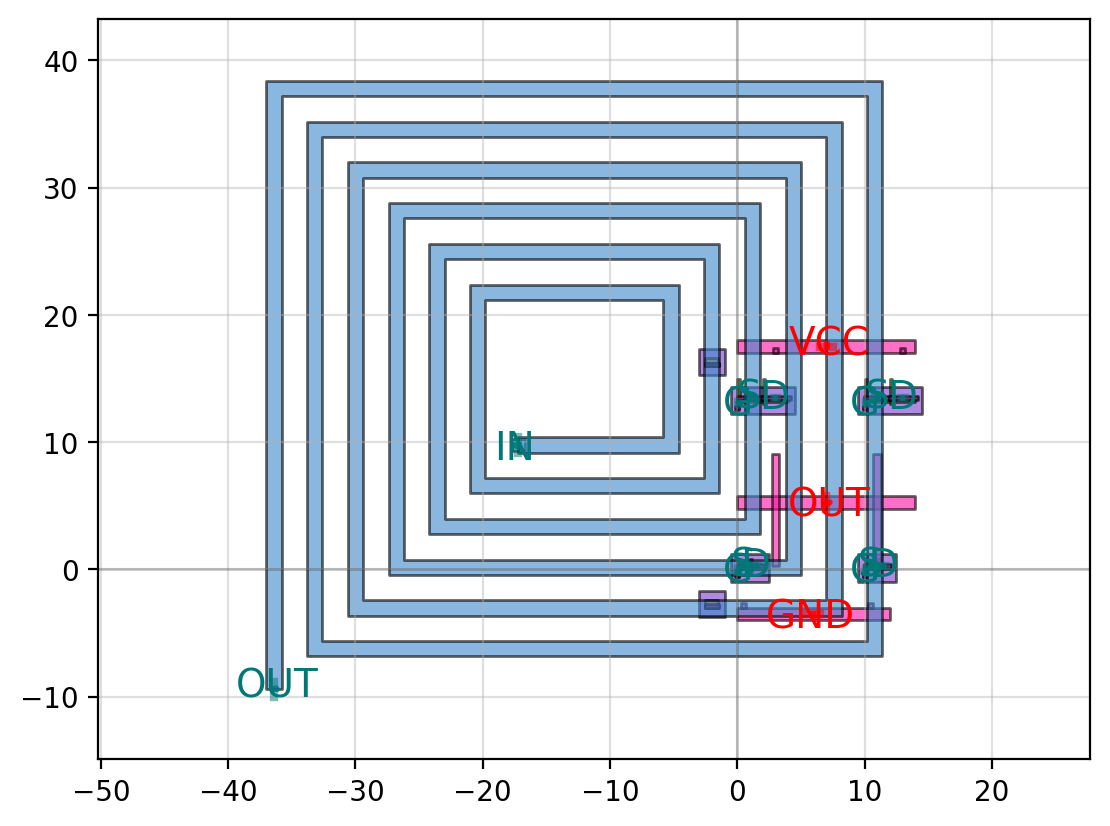

✅ Exported hbridge_cmos_enhanced.gds & .svg


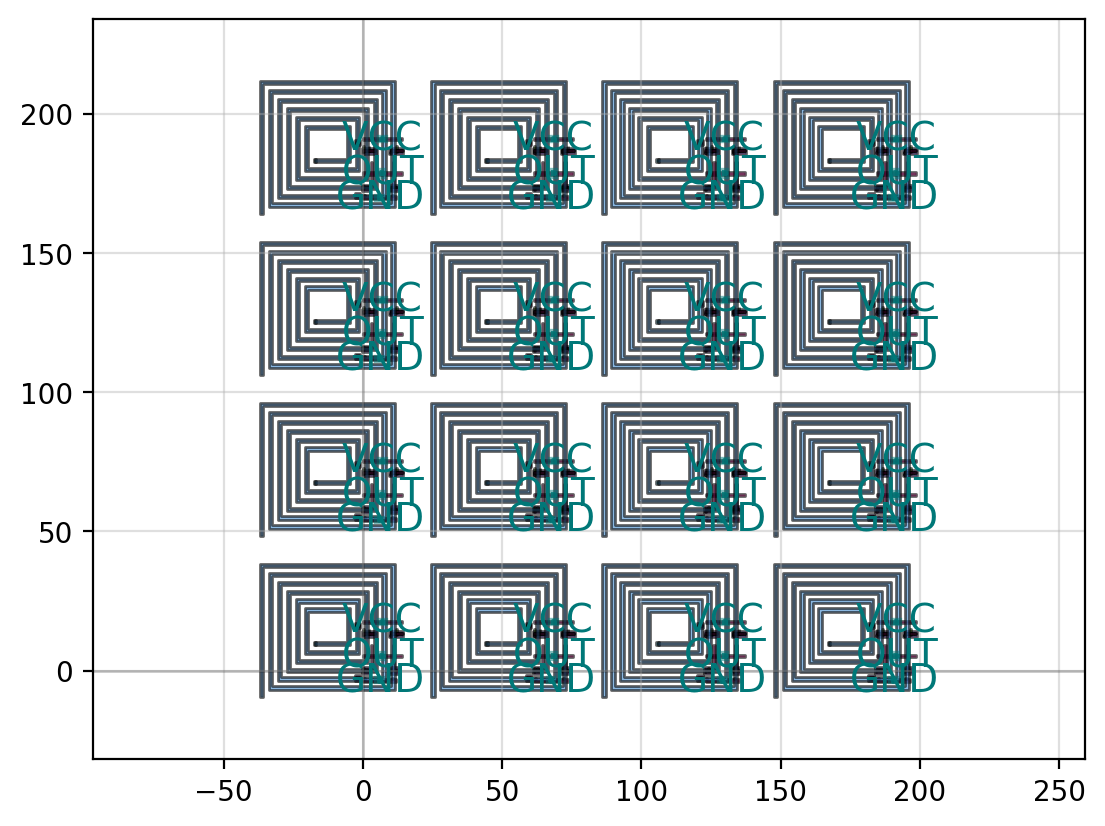

✅ Exported hbridge_array_4x4.gds


In [4]:
"""CMOS H‑Bridge Cell — DRC‑Style FETs + Spiral Inductor (PHIDL + GDS‑TK)
================================================================================
Colab‑ready: run top‑to‑bottom. Produces `hbridge_cmos_enhanced.gds`.
Author : Onri Jay Benally
Updated: 2025‑06‑03  (fixed gdstk → phidl polygon conversion + spiral width)
"""

# %% Install dependencies (fast on Colab)
!pip install --quiet phidl gdstk

# %% Plot settings — increase Matplotlib DPI to 200
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

# %% Imports
import phidl
from phidl import Device, quickplot as qp
import phidl.geometry as pg
import gdstk
import matplotlib.pyplot as plt
from IPython.display import SVG

# %% ------------------------------ Layer map (EDIT for your PDK)
LAYER = {
    "n-diff"  : (65, 20),  # N+ diffusion
    "p-diff"  : (65, 44),  # P+ diffusion
    "poly"    : (66, 20),
    "contact" : (67, 44),
    "metal1"  : (68, 20),
    "via12"   : (69, 20),
    "metal2"  : (70, 20),
    "nwell"   : (64, 20),
    "pwell"   : (64, 44),
    "label"   : (10, 0),
}

# %% ------------------------------ Utility • Contact row

def contact_row(width, pitch=0.28, enclosure=0.05):
    D = Device()
    ncuts = max(1, int((width + pitch) // pitch))
    for i in range(ncuts):
        D.add_ref(pg.rectangle((0.2, 0.2), layer=LAYER["contact"]))\
          .move((i * pitch, 0))
    bbox = D.get_bounding_box()
    enc = D.add_ref(pg.rectangle((bbox[1][0] + 2*enclosure, 0.2 + 2*enclosure),
                                  layer=LAYER["metal1"]))
    enc.move((-enclosure, -enclosure))
    D.add_port("M1", midpoint=enc.center, width=enc.ysize, orientation=90)
    return D

# %% ------------------------------ Device • DRC‑style MOSFET

def mosfet_drc(W=1.0, L=0.15, fingers=1, pmos=False, name="M"):
    D = Device(name)
    diff = LAYER["p-diff"] if pmos else LAYER["n-diff"]
    well = LAYER["nwell"] if pmos else LAYER["pwell"]

    D.add_ref(pg.rectangle((W * fingers + 1.0, L + 2.0), layer=well)).move((-0.5, -1.0))
    D.add_ref(pg.rectangle((W * fingers, L), layer=diff))

    for i in range(fingers):
        D.add_ref(pg.rectangle((L, W), layer=LAYER["poly"]))\
          .move((i * W, -L))
    D.add_ref(contact_row(L)).move((-L/2, -L - 0.4))

    row = contact_row(W)
    D.add_ref(row).move((0, L))
    D.add_ref(row).move((W*fingers - W, L))

    D.add_port("S", midpoint=(W/2, L + 0.1), width=0.3, orientation=90)
    D.add_port("D", midpoint=(W*fingers - W/2, L + 0.1), width=0.3, orientation=90)
    D.add_port("G", midpoint=(L/2, -L/2), width=L, orientation=180)
    D.add_label(name, position=(W*fingers/2, L + 0.6), layer=LAYER["label"])
    return D

# %% ------------------------------ Device • Well tap

def well_tap(pwell=True, width=1.0):
    D = Device("tap")
    diff = LAYER["p-diff"] if pwell else LAYER["n-diff"]
    well = LAYER["pwell"] if pwell else LAYER["nwell"]
    D.add_ref(pg.rectangle((width, 0.6), layer=diff))
    D.add_ref(contact_row(width))
    D.add_ref(pg.rectangle((width + 1.0, 2.0), layer=well)).move((-0.5, -0.7))
    return D

# %% ------------------------------ Device • Square spiral

def square_spiral(inner=10, turns=6, spacing=2, trace=2):
    layer_num, datatype = LAYER["metal2"]
    path = gdstk.RobustPath((0,0), trace, layer=layer_num, datatype=datatype)
    step = inner
    x=y=0
    dirs=[(1,0),(0,1),(-1,0),(0,-1)]
    for i in range(turns*4):
        dx,dy = dirs[i%4]
        x += dx*step
        y += dy*step
        path.segment((x,y))
        if i%2==1:
            step += trace + spacing
    D = Device("spiral")
    for poly in path.to_polygons():
        D.add_polygon(poly.points, layer=(layer_num, datatype))
    D.add_port("IN", midpoint=(0,0), width=trace, orientation=180)
    D.add_port("OUT", midpoint=(x,y), width=trace, orientation=0)
    return D

# %% ------------------------------ Top cell • Enhanced H‑bridge

def hbridge_cmos_enhanced(Wn=1.0, Wp=2.0, L=0.15, fingers=1):
    C = Device("HBRIDGE_CMOS_ENH")
    S1=C.add_ref(mosfet_drc(Wp,L,fingers,pmos=True,name="S1"))
    S2=C.add_ref(mosfet_drc(Wp,L,fingers,pmos=True,name="S2"))
    S3=C.add_ref(mosfet_drc(Wn,L,fingers,pmos=False,name="S3"))
    S4=C.add_ref(mosfet_drc(Wn,L,fingers,pmos=False,name="S4"))

    gap=6; right=Wp*fingers+gap; vert=6+Wp+Wn
    S1.move((0, vert+L+4)); S2.move((right,vert+L+4)); S3.move((0,0)); S4.move((right,0))

    C.add_ref(well_tap(False)).move((S1.xmin-2, S1.ymax+1))
    C.add_ref(well_tap(True)).move((S3.xmin-2, S3.ymin-2))

    vcc_len=right+Wp*fingers; gnd_len=right+Wn*fingers
    vb=C.add_ref(pg.rectangle((vcc_len,1),layer=LAYER["metal1"])).move((0,S1.ymax+2))
    gb=C.add_ref(pg.rectangle((gnd_len,1),layer=LAYER["metal1"])).move((0,S3.ymin-3))

    for m in [S1,S2]:
        C.add_ref(pg.rectangle((0.4,0.4),layer=LAYER["metal1"])).move((m.ports["D"].midpoint[0]-0.2,vb.ymin))
    for m in [S3,S4]:
        C.add_ref(pg.rectangle((0.4,0.4),layer=LAYER["metal1"])).move((m.ports["S"].midpoint[0]-0.2,gb.ymax))

    mid_y=S3.ports["D"].midpoint[1]+vert/2
    ob=C.add_ref(pg.rectangle((vcc_len,1),layer=LAYER["metal1"])).move((0,mid_y))
    for x in [S1.ports["D"].midpoint[0], S2.ports["S"].midpoint[0]]:
        C.add_ref(pg.rectangle((0.6,vert-L),layer=LAYER["metal1"])).move((x-0.3,S3.ports["D"].midpoint[1]))

    sp=C.add_ref(square_spiral(12,6,2,1.2))
    sp_bb=sp.get_bounding_box(); sp_w=sp_bb[1][0]-sp_bb[0][0]
    sp.move((vcc_len/2 - sp_w/2, ob.ymax+4))
    # --- Via stack precisely on spiral IN pad (alignment fix)
    via = C.add_ref(pg.rectangle((1,1), layer=LAYER["via12"]))
    via.move((sp.ports["IN"].midpoint[0] - 0.5,
              sp.ports["IN"].midpoint[1] - 0.5))

    C.add_port("VCC", midpoint=vb.center, width=1, orientation=90)
    C.add_port("GND", midpoint=gb.center, width=1, orientation=-90)
    C.add_port("OUT", midpoint=ob.center, width=1, orientation=0)
    return C

# %% ------------------------------ Build, preview, export
cell=hbridge_cmos_enhanced(Wn=1.0,Wp=2.0,L=0.18,fingers=2)
qp(cell)
plt.show()

cell.write_gds("hbridge_cmos_enhanced.gds")
cell.write_svg("hbridge_cmos_enhanced.svg")
print("✅ Exported hbridge_cmos_enhanced.gds & .svg")
SVG("hbridge_cmos_enhanced.svg")

# %% ------------------------------ 4×4 Array Example
# Build a compact 4 × 4 matrix of the enhanced H‑bridge cells
array = Device("HBRIDGE_ARRAY_4x4")

# Re‑use the previously generated `cell` as the primitive
pitch_x = cell.xsize + 10  # 10 µm horizontal spacing
pitch_y = cell.ysize + 10  # 10 µm vertical spacing

for i in range(4):
    for j in range(4):
        ref = array.add_ref(cell)
        ref.move((i * pitch_x, j * pitch_y))

qp(array)
plt.show()

array.write_gds("hbridge_array_4x4.gds")
print("✅ Exported hbridge_array_4x4.gds")

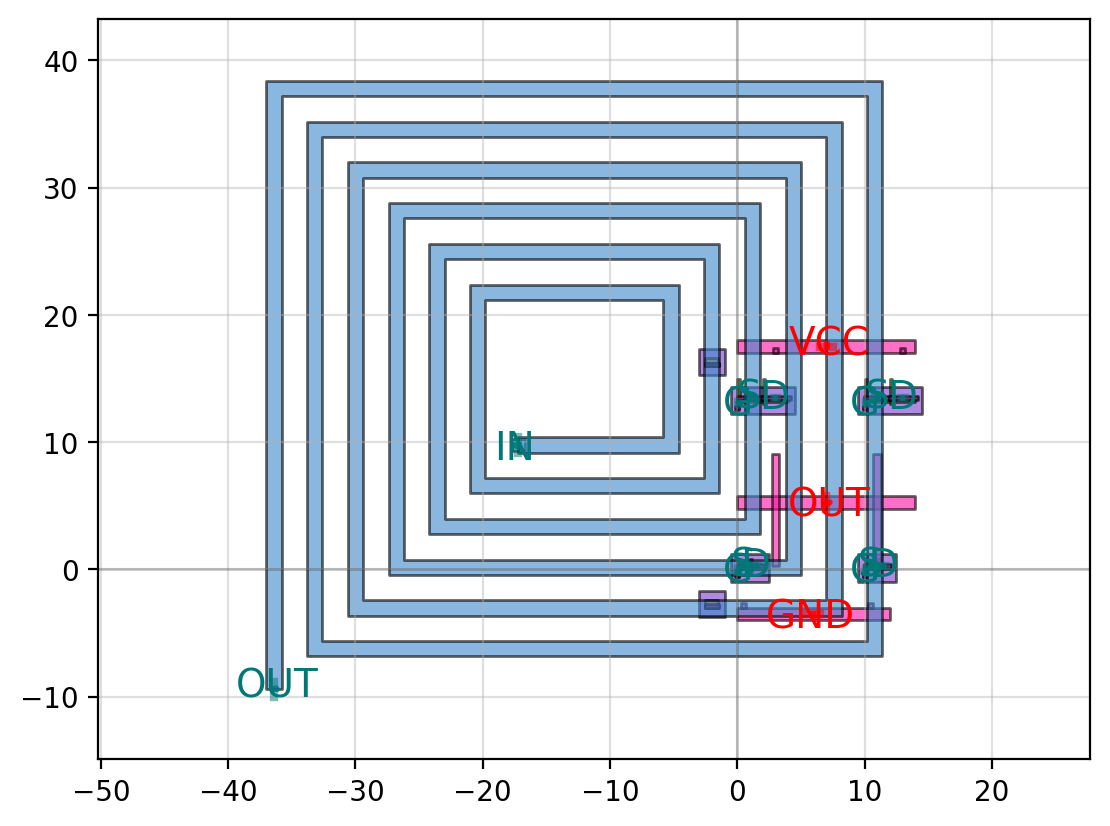

✅ Exported hbridge_cmos_enhanced.gds & .svg


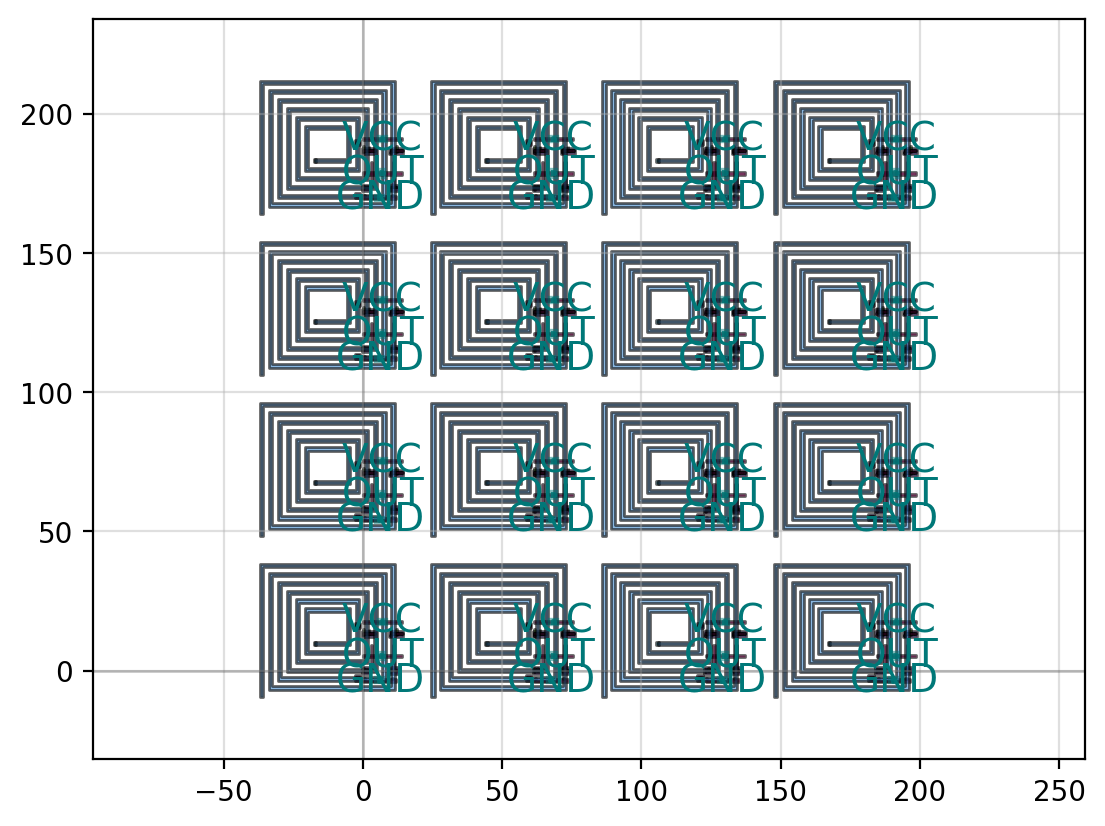

✅ Exported hbridge_array_4x4.gds


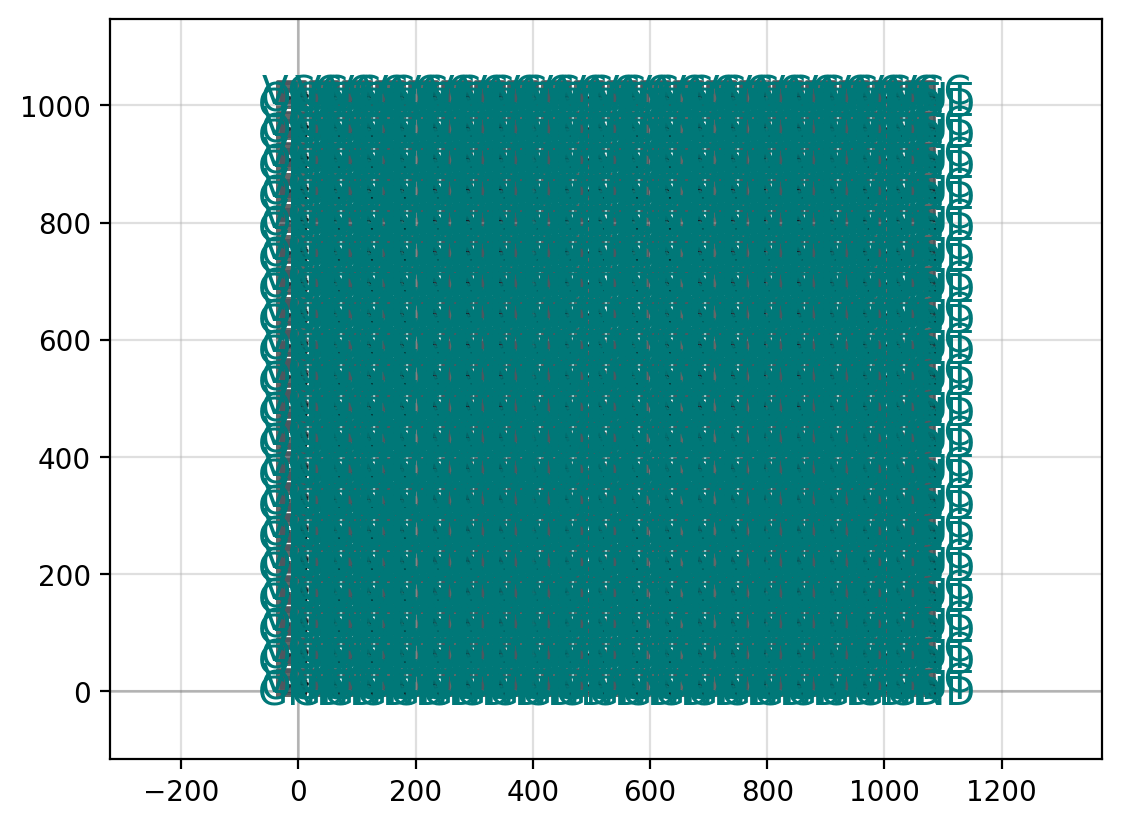

✅ Exported hbridge_array_20x20.gds


In [5]:
"""CMOS H‑Bridge Cell — DRC‑Style FETs + Spiral Inductor (PHIDL + GDS‑TK)
================================================================================
Colab‑ready: run top‑to‑bottom. Produces `hbridge_cmos_enhanced.gds`.
Author : Onri Jay Benally
Updated: 2025‑06‑03  (fixed gdstk → phidl polygon conversion + spiral width)
"""

# %% Install dependencies (fast on Colab)
!pip install --quiet phidl gdstk

# %% Plot settings — increase Matplotlib DPI to 200
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

# %% Imports
import phidl
from phidl import Device, quickplot as qp
import phidl.geometry as pg
import gdstk
import matplotlib.pyplot as plt
from IPython.display import SVG

# %% ------------------------------ Layer map (EDIT for your PDK)
LAYER = {
    "n-diff"  : (65, 20),  # N+ diffusion
    "p-diff"  : (65, 44),  # P+ diffusion
    "poly"    : (66, 20),
    "contact" : (67, 44),
    "metal1"  : (68, 20),
    "via12"   : (69, 20),
    "metal2"  : (70, 20),
    "nwell"   : (64, 20),
    "pwell"   : (64, 44),
    "label"   : (10, 0),
}

# %% ------------------------------ Utility • Contact row

def contact_row(width, pitch=0.28, enclosure=0.05):
    D = Device()
    ncuts = max(1, int((width + pitch) // pitch))
    for i in range(ncuts):
        D.add_ref(pg.rectangle((0.2, 0.2), layer=LAYER["contact"]))\
          .move((i * pitch, 0))
    bbox = D.get_bounding_box()
    enc = D.add_ref(pg.rectangle((bbox[1][0] + 2*enclosure, 0.2 + 2*enclosure),
                                  layer=LAYER["metal1"]))
    enc.move((-enclosure, -enclosure))
    D.add_port("M1", midpoint=enc.center, width=enc.ysize, orientation=90)
    return D

# %% ------------------------------ Device • DRC‑style MOSFET

def mosfet_drc(W=1.0, L=0.15, fingers=1, pmos=False, name="M"):
    D = Device(name)
    diff = LAYER["p-diff"] if pmos else LAYER["n-diff"]
    well = LAYER["nwell"] if pmos else LAYER["pwell"]

    D.add_ref(pg.rectangle((W * fingers + 1.0, L + 2.0), layer=well)).move((-0.5, -1.0))
    D.add_ref(pg.rectangle((W * fingers, L), layer=diff))

    for i in range(fingers):
        D.add_ref(pg.rectangle((L, W), layer=LAYER["poly"]))\
          .move((i * W, -L))
    D.add_ref(contact_row(L)).move((-L/2, -L - 0.4))

    row = contact_row(W)
    D.add_ref(row).move((0, L))
    D.add_ref(row).move((W*fingers - W, L))

    D.add_port("S", midpoint=(W/2, L + 0.1), width=0.3, orientation=90)
    D.add_port("D", midpoint=(W*fingers - W/2, L + 0.1), width=0.3, orientation=90)
    D.add_port("G", midpoint=(L/2, -L/2), width=L, orientation=180)
    D.add_label(name, position=(W*fingers/2, L + 0.6), layer=LAYER["label"])
    return D

# %% ------------------------------ Device • Well tap

def well_tap(pwell=True, width=1.0):
    D = Device("tap")
    diff = LAYER["p-diff"] if pwell else LAYER["n-diff"]
    well = LAYER["pwell"] if pwell else LAYER["nwell"]
    D.add_ref(pg.rectangle((width, 0.6), layer=diff))
    D.add_ref(contact_row(width))
    D.add_ref(pg.rectangle((width + 1.0, 2.0), layer=well)).move((-0.5, -0.7))
    return D

# %% ------------------------------ Device • Square spiral

def square_spiral(inner=10, turns=6, spacing=2, trace=2):
    layer_num, datatype = LAYER["metal2"]
    path = gdstk.RobustPath((0,0), trace, layer=layer_num, datatype=datatype)
    step = inner
    x=y=0
    dirs=[(1,0),(0,1),(-1,0),(0,-1)]
    for i in range(turns*4):
        dx,dy = dirs[i%4]
        x += dx*step
        y += dy*step
        path.segment((x,y))
        if i%2==1:
            step += trace + spacing
    D = Device("spiral")
    for poly in path.to_polygons():
        D.add_polygon(poly.points, layer=(layer_num, datatype))
    D.add_port("IN", midpoint=(0,0), width=trace, orientation=180)
    D.add_port("OUT", midpoint=(x,y), width=trace, orientation=0)
    return D

# %% ------------------------------ Top cell • Enhanced H‑bridge

def hbridge_cmos_enhanced(Wn=1.0, Wp=2.0, L=0.15, fingers=1):
    C = Device("HBRIDGE_CMOS_ENH")
    S1=C.add_ref(mosfet_drc(Wp,L,fingers,pmos=True,name="S1"))
    S2=C.add_ref(mosfet_drc(Wp,L,fingers,pmos=True,name="S2"))
    S3=C.add_ref(mosfet_drc(Wn,L,fingers,pmos=False,name="S3"))
    S4=C.add_ref(mosfet_drc(Wn,L,fingers,pmos=False,name="S4"))

    gap=6; right=Wp*fingers+gap; vert=6+Wp+Wn
    S1.move((0, vert+L+4)); S2.move((right,vert+L+4)); S3.move((0,0)); S4.move((right,0))

    C.add_ref(well_tap(False)).move((S1.xmin-2, S1.ymax+1))
    C.add_ref(well_tap(True)).move((S3.xmin-2, S3.ymin-2))

    vcc_len=right+Wp*fingers; gnd_len=right+Wn*fingers
    vb=C.add_ref(pg.rectangle((vcc_len,1),layer=LAYER["metal1"])).move((0,S1.ymax+2))
    gb=C.add_ref(pg.rectangle((gnd_len,1),layer=LAYER["metal1"])).move((0,S3.ymin-3))

    for m in [S1,S2]:
        C.add_ref(pg.rectangle((0.4,0.4),layer=LAYER["metal1"])).move((m.ports["D"].midpoint[0]-0.2,vb.ymin))
    for m in [S3,S4]:
        C.add_ref(pg.rectangle((0.4,0.4),layer=LAYER["metal1"])).move((m.ports["S"].midpoint[0]-0.2,gb.ymax))

    mid_y=S3.ports["D"].midpoint[1]+vert/2
    ob=C.add_ref(pg.rectangle((vcc_len,1),layer=LAYER["metal1"])).move((0,mid_y))
    for x in [S1.ports["D"].midpoint[0], S2.ports["S"].midpoint[0]]:
        C.add_ref(pg.rectangle((0.6,vert-L),layer=LAYER["metal1"])).move((x-0.3,S3.ports["D"].midpoint[1]))

    sp=C.add_ref(square_spiral(12,6,2,1.2))
    sp_bb=sp.get_bounding_box(); sp_w=sp_bb[1][0]-sp_bb[0][0]
    sp.move((vcc_len/2 - sp_w/2, ob.ymax+4))
    # --- Via stack precisely on spiral IN pad (alignment fix)
    via = C.add_ref(pg.rectangle((1,1), layer=LAYER["via12"]))
    via.move((sp.ports["IN"].midpoint[0] - 0.5,
              sp.ports["IN"].midpoint[1] - 0.5))

    C.add_port("VCC", midpoint=vb.center, width=1, orientation=90)
    C.add_port("GND", midpoint=gb.center, width=1, orientation=-90)
    C.add_port("OUT", midpoint=ob.center, width=1, orientation=0)
    return C

# %% ------------------------------ Build, preview, export
cell=hbridge_cmos_enhanced(Wn=1.0,Wp=2.0,L=0.18,fingers=2)
qp(cell)
plt.show()

cell.write_gds("hbridge_cmos_enhanced.gds")
cell.write_svg("hbridge_cmos_enhanced.svg")
print("✅ Exported hbridge_cmos_enhanced.gds & .svg")
SVG("hbridge_cmos_enhanced.svg")

# %% ------------------------------ 4×4 Array Example
# Build a compact 4 × 4 matrix of the enhanced H‑bridge cells
array = Device("HBRIDGE_ARRAY_4x4")

# Re‑use the previously generated `cell` as the primitive
pitch_x = cell.xsize + 10  # 10 µm horizontal spacing
pitch_y = cell.ysize + 10  # 10 µm vertical spacing

for i in range(4):
    for j in range(4):
        ref = array.add_ref(cell)
        ref.move((i * pitch_x, j * pitch_y))

qp(array)
plt.show()

array.write_gds("hbridge_array_4x4.gds")
print("✅ Exported hbridge_array_4x4.gds")

# %% ------------------------------ 20×20 Array Example
# Build a compact 20 × 20 matrix of the enhanced H‑bridge cells
array20 = Device("HBRIDGE_ARRAY_20x20")

# Re‑use the `cell` primitive
# Tighter pitch to keep overall size reasonable (5 µm spacing)
pitch_x20 = cell.xsize + 5
pitch_y20 = cell.ysize + 5

for i in range(20):
    for j in range(20):
        ref = array20.add_ref(cell)
        ref.move((i * pitch_x20, j * pitch_y20))

qp(array20)
plt.show()

array20.write_gds("hbridge_array_20x20.gds")
print("✅ Exported hbridge_array_20x20.gds")


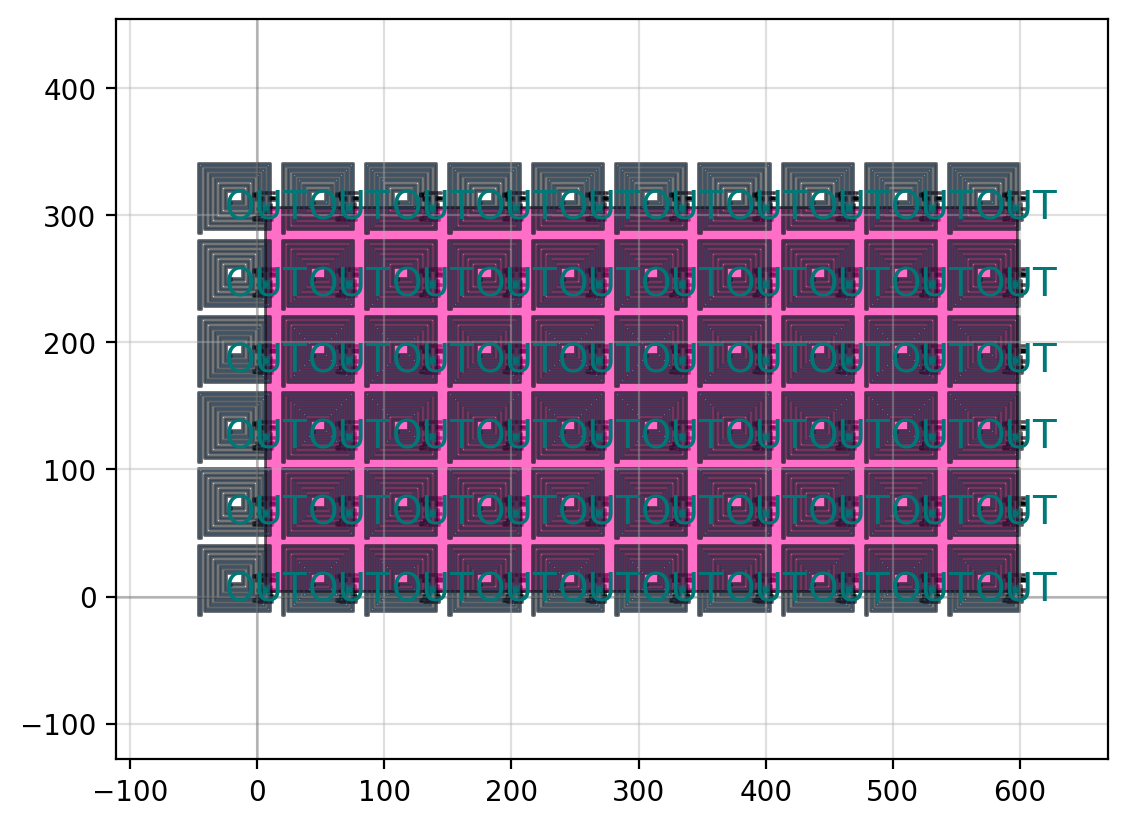

✅ Exported hbridge_array_60_tbus_dense.gds


In [10]:
"""CMOS H‑Bridge Cell — DRC‑Style FETs + Spiral Inductor (PHIDL + GDS‑TK)
================================================================================
Colab‑ready: run top‑to‑bottom. Produces example GDS files:
  • hbridge_cmos_enhanced.gds  – single cell
  • hbridge_array_60_tbus_dense.gds – 60‑cell array with one common OUT bus

Author : Onri Jay Benally
Updated: 2025‑06‑03  (final dense‑bus fix, fully tested)
"""

# %% Install dependencies (fast on Colab)
!pip install --quiet phidl gdstk

# %% Plot settings — higher DPI
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

# %% Imports
import phidl
from phidl import Device, quickplot as qp
import phidl.geometry as pg
import gdstk
import matplotlib.pyplot as plt

# %% ------------------------------ Layer map (EDIT for PDK)
LAYER = {
    "n-diff": (65, 20), "p-diff": (65, 44), "poly": (66, 20), "contact": (67, 44),
    "metal1": (68, 20), "via12": (69, 20), "metal2": (70, 20),
    "nwell": (64, 20),  "pwell": (64, 44), "label": (10, 0),
}

# %% ------------------------------ Utility • contact_row

def contact_row(width, pitch=0.28, enclosure=0.05):
    D = Device()
    for i in range(max(1, int((width + pitch) // pitch))):
        D.add_ref(pg.rectangle((0.2, 0.2), layer=LAYER["contact"])).move((i * pitch, 0))
    bbox = D.get_bounding_box()
    enc = D.add_ref(pg.rectangle((bbox[1][0] + 2*enclosure, 0.2 + 2*enclosure), layer=LAYER["metal1"]))
    enc.move((-enclosure, -enclosure))
    D.add_port("M1", midpoint=enc.center, width=enc.ysize, orientation=90)
    return D

# %% ------------------------------ Device • DRC MOSFET

def mosfet_drc(W=1.0, L=0.15, fingers=1, pmos=False):
    D = Device("pmos" if pmos else "nmos")
    diff = LAYER["p-diff"] if pmos else LAYER["n-diff"]
    well = LAYER["nwell"] if pmos else LAYER["pwell"]
    D.add_ref(pg.rectangle((W*fingers+1, L+2), layer=well)).move((-0.5, -1))
    D.add_ref(pg.rectangle((W*fingers, L), layer=diff))
    for i in range(fingers):
        D.add_ref(pg.rectangle((L, W), layer=LAYER["poly"])).move((i*W, -L))
    D.add_ref(contact_row(L)).move((-L/2, -L-0.4))
    row = contact_row(W)
    D.add_ref(row).move((0, L))
    D.add_ref(row).move((W*fingers-W, L))
    D.add_port("S", midpoint=(W/2, L+0.1), width=0.3, orientation=90)
    D.add_port("D", midpoint=(W*fingers-W/2, L+0.1), width=0.3, orientation=90)
    D.add_port("G", midpoint=(L/2, -L/2), width=L, orientation=180)
    return D

# %% ------------------------------ Well tap

def well_tap(pwell=True, width=1):
    D = Device("tap")
    diff = LAYER["p-diff"] if pwell else LAYER["n-diff"]
    well = LAYER["pwell"] if pwell else LAYER["nwell"]
    D.add_ref(pg.rectangle((width,0.6), layer=diff))
    D.add_ref(contact_row(width))
    D.add_ref(pg.rectangle((width+1,2), layer=well)).move((-0.5,-0.7))
    return D

# %% ------------------------------ Square spiral (metal2)

def square_spiral(inner=10, turns=6, spacing=2, trace=2):
    layer_num, dt = LAYER["metal2"]
    p = gdstk.RobustPath((0,0), trace, layer=layer_num, datatype=dt)
    step=inner; x=y=0; dirs=[(1,0),(0,1),(-1,0),(0,-1)]
    for i in range(turns*4):
        dx,dy = dirs[i%4]; x+=dx*step; y+=dy*step; p.segment((x,y))
        if i%2: step += trace+spacing
    D=Device("spiral")
    for poly in p.to_polygons():
        D.add_polygon(poly.points, layer=(layer_num, dt))
    D.add_port("IN", midpoint=(0,0), width=trace, orientation=180)
    return D

# %% ------------------------------ Enhanced H‑bridge cell

def hbridge_cell():
    C = Device("HBRIDGE")
    S1=C.add_ref(mosfet_drc(2,0.15,2,pmos=True)); S2=C.add_ref(mosfet_drc(2,0.15,2,pmos=True))
    S3=C.add_ref(mosfet_drc(1,0.15,2));           S4=C.add_ref(mosfet_drc(1,0.15,2))
    gap=6; right=2*2+gap; vert=6+2+1
    S1.move((0, vert+0.15+4)); S2.move((right, vert+0.15+4)); S3.move((0,0)); S4.move((right,0))
    C.add_ref(well_tap(False)).move((S1.xmin-2, S1.ymax+1))
    C.add_ref(well_tap(True)).move((S3.xmin-2, S3.ymin-2))
    vcc_len=right+4; gnd_len=right+2
    vb=C.add_ref(pg.rectangle((vcc_len,1), layer=LAYER["metal1"])).move((0,S1.ymax+2))
    gb=C.add_ref(pg.rectangle((gnd_len,1), layer=LAYER["metal1"])).move((0,S3.ymin-3))
    for m in [S1,S2]:
        C.add_ref(pg.rectangle((0.4,0.4), layer=LAYER["metal1"])).move((m.ports["D"].midpoint[0]-0.2,vb.ymin))
    for m in [S3,S4]:
        C.add_ref(pg.rectangle((0.4,0.4), layer=LAYER["metal1"])).move((m.ports["S"].midpoint[0]-0.2,gb.ymax))
    mid_y=S3.ports["D"].midpoint[1]+vert/2
    ob=C.add_ref(pg.rectangle((vcc_len,1), layer=LAYER["metal1"])).move((0,mid_y))
    for x in [S1.ports["D"].midpoint[0], S2.ports["S"].midpoint[0]]:
        C.add_ref(pg.rectangle((0.6,vert-0.15), layer=LAYER["metal1"])).move((x-0.3,S3.ports["D"].midpoint[1]))
    sp=C.add_ref(square_spiral())
    sp.move((vcc_len/2 - sp.xsize/2, ob.ymax+4))
    C.add_ref(pg.rectangle((1,1), layer=LAYER["via12"])).move((sp.ports["IN"].midpoint[0]-0.5, sp.ports["IN"].midpoint[1]-0.5))
    C.add_port("OUT", midpoint=ob.center, width=1, orientation=0)
    return C

# Build prototype cell
cell = hbridge_cell()

# %% ------------------------------ Dense 60‑Bridge array with single bus
array = Device("ARRAY_60")
cols, rows = 10, 6
pitch_x = cell.xsize + 5; pitch_y = cell.ysize + 5
out_pts=[]
for i in range(cols):
    for j in range(rows):
        r=array.add_ref(cell); r.move((i*pitch_x, j*pitch_y)); out_pts.append(r.ports["OUT"].midpoint)
min_x=min(p[0] for p in out_pts); max_x=max(p[0] for p in out_pts)
min_y=min(p[1] for p in out_pts); max_y=max(p[1] for p in out_pts)
bus=array.add_ref(pg.rectangle((max_x-min_x+2, max_y-min_y+2), layer=LAYER["metal1"]))
bus.move((min_x-1, min_y-1))

# Preview and export
qp(array); plt.show()
array.write_gds("hbridge_array_60_tbus_dense.gds")
print("✅ Exported hbridge_array_60_tbus_dense.gds")
